In [1]:
# Python ≥3.7 is required
import sys
assert sys.version_info >= (3, 7)

# Is this notebook running on Colab or Kaggle?
IS_COLAB = "google.colab" in sys.modules

# Scikit-Learn ≥1.0.1 is required
from packaging import version
import sklearn

assert version.parse(sklearn.__version__) >= version.parse("1.0.1")

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

import pandas as pd

Deze dataset bevat data van cardiotocogrammen die gemaakt werden bij prenatale echo's. Door 3 experten werd een classificatie gedaan, zowel met betrekking tot het morfologisch patroon (CLASS) als met betrekking tot de toestand van de foetus (NSP). Dus zowel de kolom CLASS als de kolom NSP bevatten een 'score' die de 3 experten aan de data gaven.  
Daarom kan deze dataset gebruikt worden voor een 10-class of voor een 3-class classificatie.  


* LB - FHR-basislijn (slagen per minuut)    
* AC - aantal versnellingen per seconde  
* FM - aantal foetale bewegingen per seconde  
* UC - aantal baarmoedersamentrekkingen per seconde  
* DL - aantal lichtvertragingen per seconde  
* DS - aantal ernstige vertragingen per seconde  
* DP - aantal langdurige vertragingen per seconde  
* ASTV - percentage van de tijd met abnormale kortetermijnvariabiliteit  
* MSTV - gemiddelde waarde van kortetermijnvariabiliteit  
* ALTV - percentage van de tijd met abnormale langetermijnvariabiliteit  
* MLTV - gemiddelde waarde van langetermijnvariabiliteit  
* Width - breedte van FHR-histogram  
* Min - minimum van FHR-histogram  
* Max - Maximum van FHR-histogram  
* Nmax - aantal histogrampieken  
* Nzeros - aantal histogramnullen  
* Mode - histogrammodus  
* Mean - histogram gemiddelde  
* Median - histogram mediaan  
* Variance - histogramvariantie  
* Tendency - histogramtendens  
* CLASS - klassecode van de FHR (1 tot 10)
* NSP - klassecode van de toestand van de foetus (1 -> N=normaal; 2 -> S=verdacht (suspect); 3 -> P=pathologisch (= dit wijst op een ziekte))


Bron: https://archive.ics.uci.edu/ml/datasets/cardiotocography 

In [3]:
if 'google.colab' in str(get_ipython()):
    colab = True
    print ('You are running on Google Colab')
else:
    colab = False
    print ('You are not running on Google Colab')

if colab:
    from google.colab import drive
    drive.mount('/content/gdrive')

You are not running on Google Colab


In [4]:
if colab:
    df = pd.read_csv('/content/gdrive/MyDrive/DataEchos.csv', delimiter=";")
else:
    df = pd.read_csv('https://raw.githubusercontent.com/HOGENT-ML/course/main/datasets/DataEchos.csv', delimiter=";")
df.head()

,LB,AC,FM,UC,DL,DS,DP,ASTV,MSTV,ALTV,...,Max,Nmax,Nzeros,Mode,Mean,Median,Variance,Tendency,CLASS,NSP
0,120.0,0.000,0.0,0.000,0.000,0.0,0.0,73.0,0.5,43.0,...,126.0,2.0,0.0,120.0,137.0,121.0,73.0,1.0,9,2.0
1,132.0,0.006,0.0,0.006,0.003,0.0,0.0,17.0,2.1,0.0,...,198.0,6.0,1.0,141.0,136.0,140.0,12.0,0.0,6,1.0
2,133.0,0.003,0.0,0.008,0.003,0.0,0.0,16.0,2.1,0.0,...,198.0,5.0,1.0,141.0,135.0,138.0,13.0,0.0,6,1.0
3,134.0,0.003,0.0,0.008,0.003,0.0,0.0,16.0,2.4,0.0,...,170.0,11.0,0.0,137.0,134.0,137.0,13.0,1.0,6,1.0
4,132.0,0.007,0.0,0.008,0.000,0.0,0.0,16.0,2.4,0.0,...,170.0,9.0,0.0,137.0,136.0,138.0,11.0,1.0,2,1.0


Geef algemene informatie over de  dataset (type van elke kolom, null waarden, ...)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2126 entries, 0 to 2125
Data columns (total 23 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   LB        2126 non-null   float64
 1   AC        2126 non-null   float64
 2   FM        2126 non-null   float64
 3   UC        2126 non-null   float64
 4   DL        2126 non-null   float64
 5   DS        2126 non-null   float64
 6   DP        2126 non-null   float64
 7   ASTV      2126 non-null   float64
 8   MSTV      2126 non-null   float64
 9   ALTV      2126 non-null   float64
 10  MLTV      2126 non-null   float64
 11  Width     2126 non-null   float64
 12  Min       2126 non-null   float64
 13  Max       2126 non-null   float64
 14  Nmax      2126 non-null   float64
 15  Nzeros    2126 non-null   float64
 16  Mode      2126 non-null   float64
 17  Mean      2126 non-null   float64
 18  Median    2126 non-null   float64
 19  Variance  2126 non-null   float64
 20  Tendency  2126 non-null   floa

Is dit een scheve (skewed) dataset? Geef het aantal records voor NSP = 1, 2 en 3.
- Ja want we hebben heel veel 1 en weinig 2 en 3. 
- **Normaal?** ja want de meeste kinderen worden gezond geboren

In [6]:
df['NSP'].value_counts()

1.0    1655
2.0     295
3.0     176
Name: NSP, dtype: int64

We willen de de classificatie doen op basis van NSP (en níet CLASS).  
Wat is X? Wat is y?

In [7]:
X = df.drop(['CLASS','NSP'], axis=1)
y = df['NSP']

Wat is X_train, y_train, X_test, y_test?

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Wat zijn de numerieke kolommen in X?

In [9]:
numerical_ix = X.select_dtypes(include=['int64', 'float64']).columns
print(numerical_ix)

Index(['LB', 'AC', 'FM', 'UC', 'DL', 'DS', 'DP', 'ASTV', 'MSTV', 'ALTV',
       'MLTV', 'Width', 'Min', 'Max', 'Nmax', 'Nzeros', 'Mode', 'Mean',
       'Median', 'Variance', 'Tendency'],
      dtype='object')


Geef de unieke waarden in NSP **gesorteerd** van klein naar groot.

In [10]:
nsp_values = np.sort(df['NSP'].unique())
print(nsp_values)


[1. 2. 3.]


Standardiseer de waarden in de numerieke kolommen.

,LB,AC,FM,UC,DL,DS,DP,ASTV,MSTV,ALTV,...,Width,Min,Max,Nmax,Nzeros,Mode,Mean,Median,Variance,Tendency
1233,-0.818907,-0.824976,-0.204261,1.218555,-0.637350,-0.064301,-0.268148,-0.859657,-0.262589,-0.367038,...,-0.500418,0.090151,-0.947494,-0.014607,-0.445313,-0.680274,-0.603307,-0.742903,-0.580514,-0.516697
480,0.692429,-0.824976,-0.204261,-1.159016,-0.637350,-0.064301,-0.268148,0.762723,-0.604484,1.233861,...,1.267146,-0.482204,1.975298,1.686204,-0.445313,0.222228,0.414302,0.281431,-0.545964,-0.516697
1111,-1.121174,-0.824976,-0.204261,-1.498669,-0.296949,-0.064301,-0.268148,-1.554963,0.535166,-0.532648,...,-0.807820,0.325826,-1.228531,-1.035093,-0.445313,-1.041275,-0.984911,-1.152636,-0.545964,-0.516697
1303,0.390162,0.464049,-0.204261,0.199596,0.043451,-0.064301,-0.268148,-0.627888,-0.490519,-0.532648,...,-0.193016,0.729841,0.794940,-0.014607,-0.445313,0.643396,0.859505,0.759453,-0.338667,-0.516697
861,0.893941,-0.051561,-0.204261,-0.140057,-0.637350,-0.064301,-0.268148,-0.048467,-0.718449,0.957844,...,-1.140840,1.335863,-0.273003,-1.035093,-0.445313,0.763729,0.859505,0.827742,-0.615063,-0.516697
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1638,-0.315128,1.495268,-0.183561,-0.140057,-0.296949,-0.064301,-0.268148,0.299186,-0.034659,-0.532648,...,0.729192,-0.684211,0.457695,0.665717,-0.445313,0.402728,0.414302,0.418008,-0.096820,1.119029
1095,-1.020419,2.268683,-0.204261,-0.819363,-0.637350,-0.064301,-0.268148,-1.439078,0.991026,-0.532648,...,-0.474801,0.224822,-0.666456,-0.694931,-0.445313,-0.379440,-0.158104,-0.333169,-0.511415,-0.516697
1130,-1.121174,0.464049,-0.204261,-0.140057,1.064653,-0.064301,-0.268148,-1.554963,1.446887,-0.532648,...,0.703575,-1.121894,-0.329211,0.665717,-0.445313,-0.379440,-0.857710,-0.811192,0.421423,-0.516697
1294,-1.826465,-0.051561,-0.204261,1.218555,0.043451,-0.064301,1.383487,-1.323194,0.307236,-0.532648,...,0.959744,-0.751547,0.851147,-0.354769,2.444122,-0.259107,-0.794109,-0.606325,0.905117,-0.516697


,LB,AC,FM,UC,DL,DS,DP,ASTV,MSTV,ALTV,...,Width,Min,Max,Nmax,Nzeros,Mode,Mean,Median,Variance,Tendency
282,-0.106532,-0.286784,0.052463,-0.402003,0.013881,0.0,-0.274094,-0.094906,-0.267724,-0.547087,...,-0.028291,0.013632,-0.037672,0.278678,-0.509868,0.062982,-0.007181,-0.068261,-0.338092,-0.556238
1999,-0.952824,-0.812247,-0.176369,1.636726,1.984984,0.0,-0.274094,0.852212,0.395360,-0.547087,...,0.049464,-0.919662,-1.334519,0.278678,-0.509868,-0.523120,-1.270786,-1.018080,0.349717,1.089298
1709,-0.318105,0.238678,-0.125518,-0.062215,0.999432,0.0,1.640073,0.733823,0.837415,-0.547087,...,0.516000,-0.573997,0.178469,1.284754,-0.509868,-0.327752,-0.539226,-0.506639,0.074593,-0.556238
988,-0.318105,2.077798,-0.201795,0.277573,-0.643153,0.0,-0.274094,-1.101220,-0.046696,-0.547087,...,0.490082,-0.435732,0.340574,1.284754,-0.509868,0.323472,0.657874,0.443180,-0.338092,1.089298
2018,-0.952824,-0.812247,-0.201795,1.296938,1.656467,0.0,1.640073,0.970602,-0.046696,-0.547087,...,0.179058,-0.573997,-0.523990,-0.056680,-0.509868,-1.565079,-1.603314,-1.821773,-0.406873,-0.556238
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
305,1.162907,-0.812247,0.332147,-1.421367,-0.643153,0.0,-0.274094,1.562552,-1.151835,0.996010,...,-0.417071,1.258023,1.097068,-0.727398,-0.509868,0.453717,0.591368,0.516243,-0.613216,-2.201774
973,-0.318105,-0.812247,-0.201795,0.277573,1.984984,0.0,-0.274094,-0.923635,0.505873,-0.238468,...,0.697431,-1.230760,-0.469955,-0.392039,0.814545,-0.197508,-1.004764,-0.433576,1.759725,1.089298
611,1.057121,0.764141,-0.074666,-0.741791,-0.643153,0.0,-0.274094,-0.864441,0.395360,-0.547087,...,0.852943,-0.815962,0.502680,0.278678,0.814545,0.779329,0.923896,0.881558,-0.303702,1.089298
2108,0.210828,-0.812247,-0.125518,1.296938,-0.314636,0.0,-0.274094,1.148187,0.947929,-0.547087,...,-0.650339,0.186464,-1.064342,-0.392039,-0.509868,-0.327752,-0.273203,-0.214387,-0.578825,1.089298


Creëer een model gebruik maken van een Random Forest Classifier.  
Bepaal  de optimale waarden voor de parameters gebruik makend van GridSearchCV.  
Gebruik volgende parametercombinaties: 
- bootstrap = True, n_estimators = 3,10,30  max_features = 4,6,8
- bootstrap = False, n_estimators = 3,10  max_features = 2,3,4
Geef de gevonden optimale waarden voor de classifier.  
Geef de accuracy.

### RandomForestClassifier


In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'bootstrap': [True],'n_estimators': [3, 10, 30], 'max_features': [4, 6, 8]},   # 9 combinaties
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},   # 6 combinaties
  ]

forest_clf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(forest_clf, param_grid, cv=5, scoring='accuracy', return_train_score=True)   # cv = 5-fold cross validation
grid_search.fit(X_train, y_train)

print(grid_search.best_params_)
print(grid_search.best_estimator_)
print(grid_search.best_score_)

{'bootstrap': True, 'max_features': 6, 'n_estimators': 30}
RandomForestClassifier(max_features=6, n_estimators=30, random_state=42)
0.9347058823529413


Stel de confusion matrix (zowel als numeriek cijferdiagramma en als genormaliseerd kleurdiagramma) op m.b.v. de TEST set en interpreteer. 

In [15]:
y_test_pred = grid_search.predict(X_test)
y_test_pred[:10]

array([1., 1., 1., 1., 1., 3., 1., 3., 2., 2.])

In [16]:
from sklearn.metrics import confusion_matrix
conf_mx = confusion_matrix(y_test, y_test_pred)
conf_mx

array([[324,   7,   2],
       [  9,  54,   1],
       [  1,   0,  28]], dtype=int64)

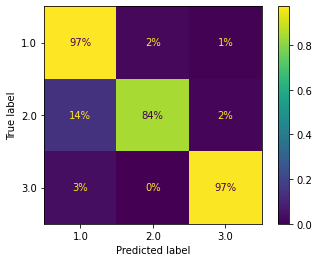

In [18]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred, normalize='true', values_format='.0%')
plt.show()


Bekijk de confusion matrix goed. Hoewel de accuracy best ok lijkt, zijn de feitelijke resultaten niet goed.

Stel dat we NSP = 2 (Suspect) en 3 (Pathologisch) zonder onderscheid volledig samennemen als zijnde Positief (~ er is iets aan de hand) en NSP = 1 (Normaal) beschouwen als zijnde Negatief (~ er is niets aan de hand).  
Bereken en geef dan de precision op basis van de voorgaande numerieke confusion matrix.

In [17]:
precision = conf_mx[1][1] + conf_mx[2][2] + conf_mx[2][1] + conf_mx[1][2] / (conf_mx[1][1] + conf_mx[2][2] + conf_mx[2][1] + conf_mx[1][2] + conf_mx[0][1] + conf_mx[2][0])

0.9302325581395349


Bereken en geef dan de recall op basis van de voorgaande confusion matrix.

0.8602150537634409


**Wat is belangrijker in dit geval: precision of recall? Leg kort uit.**
Recall omdat je geen valse negatieven wil missen (hoe meer valse negatieven, hoe kleiner het getal)

**Wat is een mogelijke verklaring voor de slechte resultaten?**
Wellicht te weinig data

Teken de ROC curve voor de testset en bereken de AUC voor de binaire classifier waarbij negatief beschouwd wordt als NSP = 1 en positief als NSP = 2 of 3. Herwerk hiervoor de dataset. 
Aangezien Random Forest geen decision function heeft, moeten we gebruik maken van de functie `predict_proba()` op de classifier. 

In [19]:
y_train
y_train_23 = [1 if x == 2 or x == 3 else 0 for x in y_train.values]
y_test_23_series = pd.Series(y_train_23)
y_test_23_series.value_counts()

0    1322
1     378
dtype: int64

1    333
2     93
dtype: int64

In [23]:
param_grid = [
    {'bootstrap': [True],'n_estimators': [3, 10, 30], 'max_features': [4, 6, 8]},   # 9 combinaties
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},   # 6 combinaties
  ]



best estimator = RandomForestClassifier(max_features=6, n_estimators=30, random_state=42)
best score = 0.9452941176470588


array([[1.        , 0.        ],
       [1.        , 0.        ],
       [0.93333333, 0.06666667],
       [1.        , 0.        ],
       [0.93333333, 0.06666667],
       [0.        , 1.        ],
       [1.        , 0.        ],
       [0.06666667, 0.93333333],
       [0.2       , 0.8       ],
       [0.        , 1.        ],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.86666667, 0.13333333],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [0.8       , 0.2       ],
       [0.63333333, 0.36666667],
       [1.        , 0.        ],
       [0.23333333, 0.76666667],
       [1.        , 0.        ],
       [0.93333333, 0.06666667],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [1.        , 0.        ],
       [0.9       , 0.1       ],
       [0.        , 1.        ],
       [0.        , 1.        ],
       [0.8       , 0.2       ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [0.

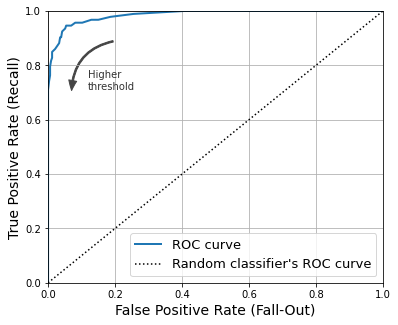

0.9859052600988084